# Аналитика в Яндекс.Афише

---

## Описание проекта

Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши.<br>

Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.<br>

У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:<br>
- лог сервера с данными о посещениях сайта Яндекс.Афиши<br>
- выгрузка всех заказов за этот период<br>
- статистика рекламных расходов.<br>

Вы изучите:<br>
- как люди пользуются продуктом<br>
- когда они начинают покупать<br>
- сколько денег приносит каждый клиент<br>
- когда клиент окупается.<br>

---

## Описание данных

Таблица `visits` (лог сервера с информацией о посещениях сайта):<br>

**Uid** — уникальный идентификатор пользователя<br>
**Device** — категория устройства пользователя<br>
**Start Ts** — дата и время начала сессии<br>
**End Ts** — дата и время окончания сессии<br>
**Source Id** — идентификатор рекламного источника, из которого пришел пользователь<br>

---

Таблица `orders` (информация о заказах):<br>

**Uid** — уникальный id пользователя, который сделал заказ<br>
**Buy Ts** — дата и время заказа<br>
**Revenue** — выручка Яндекс.Афиши с этого заказа<br>

---

Таблица `costs` (информация о затратах на маркетинг):<br>

**source_id** — идентификатор рекламного источника<br>
**dt** — дата<br>
**costs** — затраты на этот рекламный источник в этот день<br>

---

## Оглавление

* [1. Загрузка и подготовка данных к анализу.](#one)
* [2. Построим отчеты и рассчитаем метрики.](#two)
* [2.1. Продукт:](#three)
* [Сколько людей пользуются в день, неделю, месяц?](#four)
* [Сколько сессий в день?](#five)
* [Сколько длится одна сессия?](#six)
* [Как часто люди возвращаются?](#seven)
* [2.2. Продажи:](#eight)
* [Когда люди начинают покупать?](#nine)
* [Сколько раз покупают за период?](#ten)
* [Какой средний чек?](#eleven)
* [Сколько денег приносят? (LTV)](#twelve)
* [2.3. Маркетинг](#thirteen)
* [Сколько денег потратили? Всего / на каждый источник / по времени](#fourteen)
* [Сколько стоило привлечение одного покупателя из каждого источника?](#fifteen)
* [На сколько окупились расходы? (ROI)](#sixteen)
* [3. Общий вывод](#seventeen)

---

## 1. Загрузка и подготовка данных к анализу. <a class="anchor" id="one"></a>

Импортируем все необходимые библиотеки

In [9]:
import pandas as pd
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import numpy as np
from IPython.core.display import HTML 

Откроем файлы с данными. Посмотрим на первые тридцать строк методом head(), последние тридцать строк методом tail() и изучим столбцы методом info()

In [2]:
list_data = visits, orders, costs = [pd.read_csv('datasets/' + file + '.csv') 
                                     for file in ['6_visits_log', '6_orders_log', '6_costs']]

In [3]:
for (name, data) in zip(['посещениях сайта', 'заказах', 'затратах на маркетинг'], list_data):
    print('Информация о', name)
    display(data.head(30))
    display(data.tail(30))
    data.info()
    print('\n')

Информация о посещениях сайта


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


,Device,End Ts,Source Id,Start Ts,Uid
359370,desktop,2017-11-24 11:15:19,2,2017-11-24 11:15:00,17870581866064122636
359371,desktop,2018-02-14 12:26:19,3,2018-02-14 12:26:00,17871144492048360195
359372,desktop,2017-12-19 21:41:19,5,2017-12-19 21:41:00,17875181850866691027
359373,desktop,2017-08-24 11:46:19,4,2017-08-24 11:46:00,17905781220052296389
359374,touch,2018-02-27 00:32:19,1,2018-02-27 00:32:00,17922803755368507646
359375,desktop,2017-11-24 10:43:19,1,2017-11-24 10:43:00,17956827303229825606
359376,desktop,2018-01-27 11:10:19,4,2018-01-27 11:10:00,17957109797429760390
359377,desktop,2017-11-26 15:58:19,1,2017-11-26 15:58:00,17958659650920313829
359378,desktop,2017-11-13 00:02:19,3,2017-11-13 00:02:00,17962492575748350493
359379,desktop,2017-06-06 22:51:19,3,2017-06-06 22:51:00,17971145352859089550


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Информация о заказах


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


,Buy Ts,Revenue,Uid
50385,2018-05-31 22:19:00,1.53,13142765597017713277
50386,2018-05-31 22:23:00,3.67,10910587539790958081
50387,2018-05-31 22:26:00,17.60,11008267452526568440
50388,2018-05-31 22:31:00,3.67,11195922511132745019
50389,2018-05-31 22:37:00,0.73,3494439906345197228
50390,2018-05-31 22:45:00,3.48,13371827216221316036
50391,2018-05-31 22:49:00,0.61,16499949084511921710
50392,2018-05-31 22:50:00,2.44,15116668155510764243
50393,2018-05-31 22:57:00,6.60,12484396335714047199
50394,2018-05-31 22:58:00,0.85,11637259703803638683


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Информация о затратах на маркетинг


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


,source_id,dt,costs
2512,10,2018-05-02,3.50
2513,10,2018-05-03,5.35
2514,10,2018-05-04,23.06
2515,10,2018-05-05,16.41
2516,10,2018-05-06,17.36
2517,10,2018-05-07,9.08
2518,10,2018-05-08,8.09
2519,10,2018-05-09,10.63
2520,10,2018-05-10,8.16
2521,10,2018-05-11,13.23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB




#### Мы преобразовали наши файлы в датафреймы:

**visits**

- В датафрейме 359 400 строк и 5 столбцов.
- В названии столбцов присутствует верхний регистр и пробелы
- Значения в столбцах `End Ts` и `Start Ts` имеют тип *object*

**orders**

- В датафрейме 50 415 строк и 3 столбца
- В названии столбцов присутствует верхний регистр и пробелы
- Значения в столбце `Buy Ts` имеет тип *object*

**costs**

- В таблице costs 2 542 строки и 3 столбца
- Значения в столбце `dt` имеет тип *object*

#### Подготовка к анализу:

- Питон чувствителен к регистру, поэтому для удобства использования приведем отмеченные выше столбцы к нижнему регистру.
- Пробелы не позволят использовать некоторые методы в pandas, например, query, поэтому избавимся от пробелов.
- Для анализа, корректного сравнения и работы с датами приведем их к нужному типу.

#### Приведем наименование столбцов к нижнему регистру и заменим пробелы на нижнее подчеркивание:

In [4]:
for data in list_data:
    data.columns = data.columns.str.lower().str.replace(' ', '_')

#### Приведем значения в столбцах к типу *datetime*

In [5]:
for (data, column) in zip([visits] + list_data, ['end_ts', 'start_ts', 'buy_ts', 'dt']):
    data[column] = pd.to_datetime(data[column])

#### Проверим наличие дубликатов

In [6]:
for data in list_data:
    print(data.duplicated().sum())

0
0
0


Дубликатов не обнаружено

#### Посмотрим на данные столбцов каждой таблицы

In [7]:
for data in ['visits', 'orders', 'costs']:
    print(data, '\n')
    for column in eval(data).columns:
        print(column, '\n')
        print(eval(data)[column].describe(), '\n')
    print('\n')

visits 

device 

count      359400
unique          2
top       desktop
freq       262567
Name: device, dtype: object 

end_ts 

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object 

source_id 

count    359400.000000
mean          3.750515
std           1.917116
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max          10.000000
Name: source_id, dtype: float64 

start_ts 

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object 

uid 

count    3.594000e+05
mean     9.202557e+18
std      5.298433e+18
min      1.186350e+13
25%      4.613407e+18
50%      9.227413e+18
75%      1.372824e+19
max      1.844668e+19
Name: uid, dtype: float64 

In [10]:
for data in ['visits', 'orders', 'costs']:
    display(HTML(f"""<div><b>Информация о датафрейме {data}</b></div>"""))
    display(eval(data).describe(include=['object', np.number]))
    print('\n')

,device,source_id,uid
count,359400,359400.000000,3.594000e+05
unique,2,NaN,NaN
top,desktop,NaN,NaN
freq,262567,NaN,NaN
mean,NaN,3.750515,9.202557e+18
std,NaN,1.917116,5.298433e+18
min,NaN,1.000000,1.186350e+13
25%,NaN,3.000000,4.613407e+18
50%,NaN,4.000000,9.227413e+18
75%,NaN,5.000000,1.372824e+19


,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


<hr style="border: 2px solid orange;" />

Данные в порядке и на первый взгляд особых выбросов не обнаружили.

В таблице `orders` в столбце `revenue` обнаружили нулевые значения. Пока просто выделим это.

### Выводы

Мы преобразовали файлы в датафреймы:

- visits
- orders
- costs

Изучили содержимое.

Подготовили данные к анализу:

- преобразовали типы
- подготовили наименования столбцов

---

##  2. Построим отчеты и рассчитаем метрики.<a class="anchor" id="two"></a>

##  2.1. Продукт:<a class="anchor" id="three"></a>

##  Сколько людей пользуются в день, неделю, месяц?<a class="anchor" id="four"></a>

Чтобы посчитать дневное, недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, а также полную дату.

In [11]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date

display(visits.head())

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-21,2017-12-27


Посчитаем метрики. Сгруппируем данные по уникальным пользователям и найдем среднее.

In [12]:
# Распаковка DAU, MAU, WAU с помощью list comprehension и pivot_table 

list_metrics = dau_device, dau_source, wau_device, wau_source, mau_device, mau_source = [
    visits.pivot_table(
        index = season,
        columns = category,
        values = 'uid',
        aggfunc = 'nunique') 
    for season in ('session_date', 'session_week', 'session_month')
    for category in ('device', 'source_id')  
]

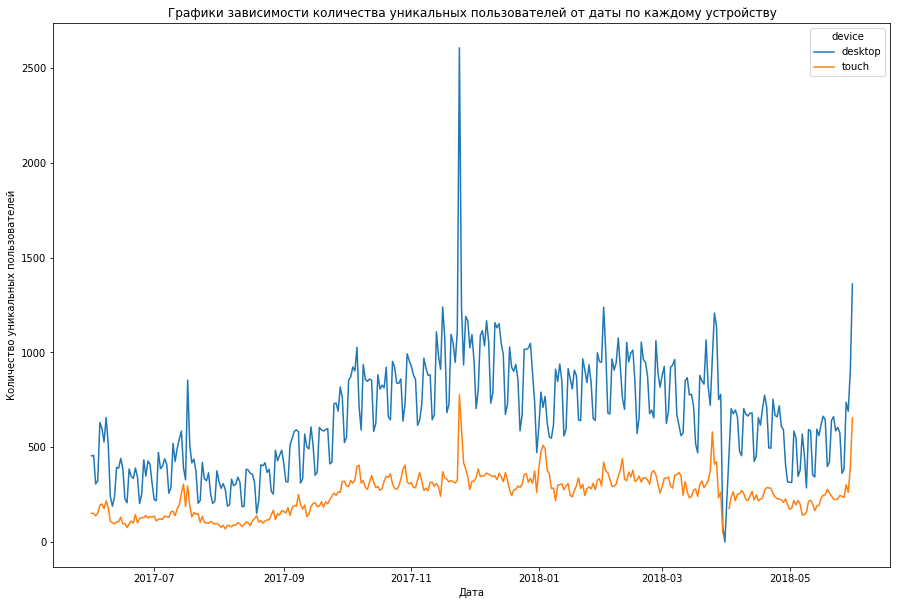

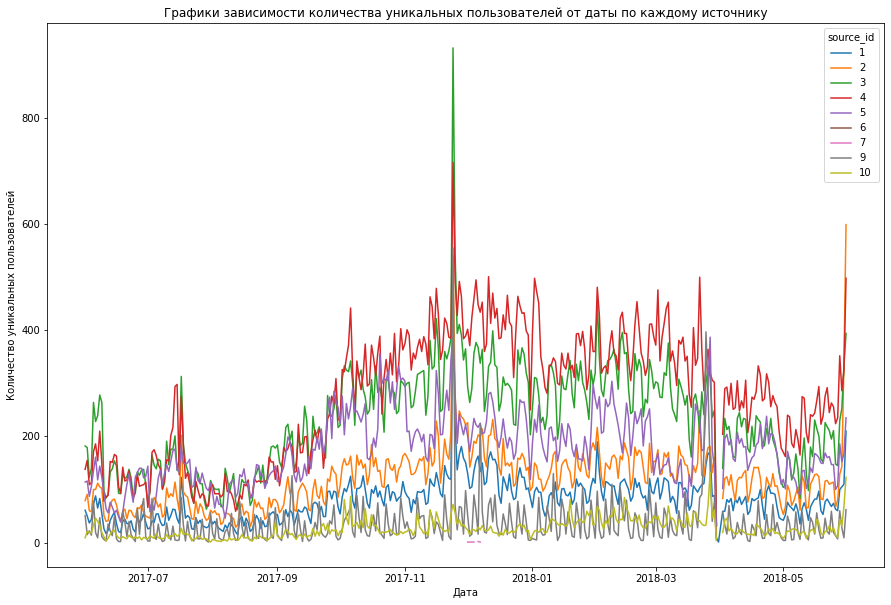

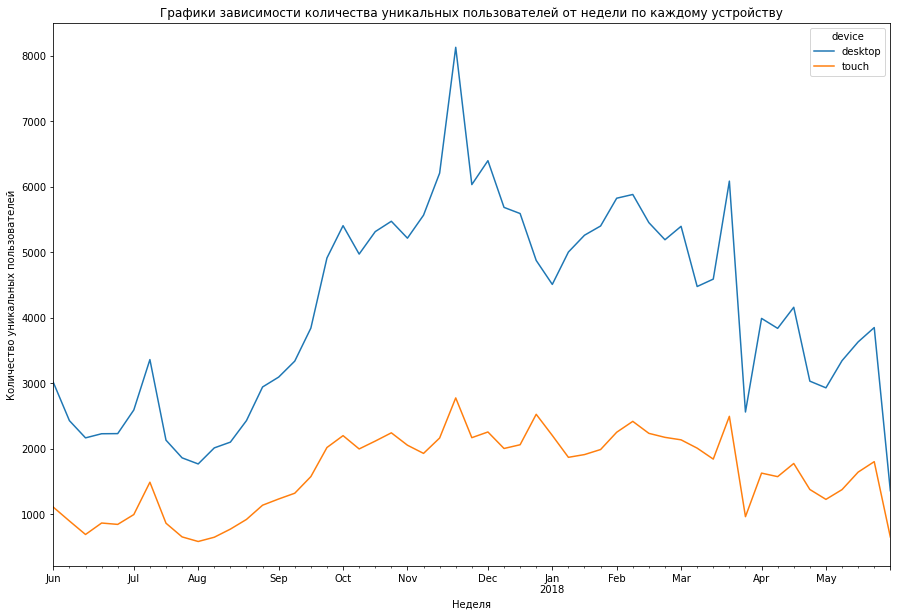

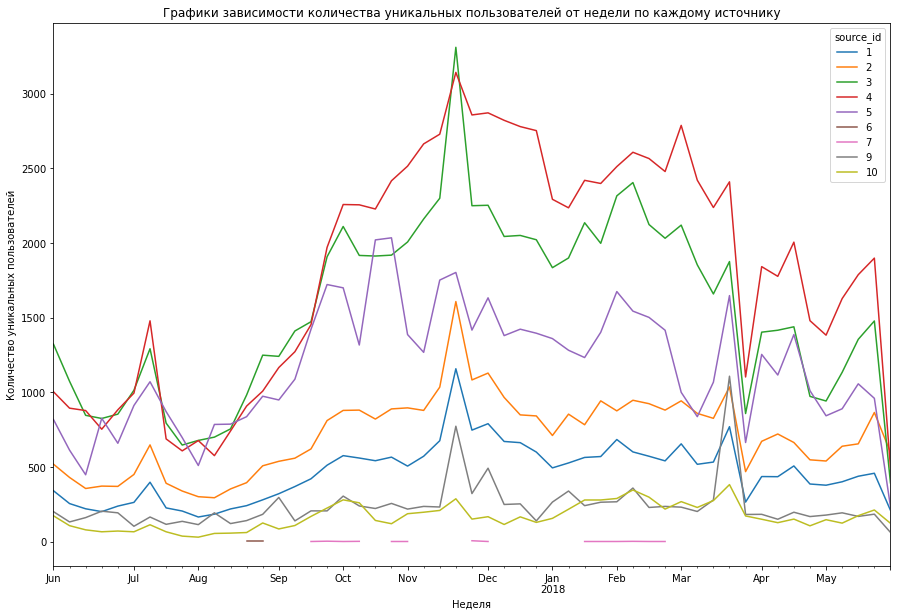

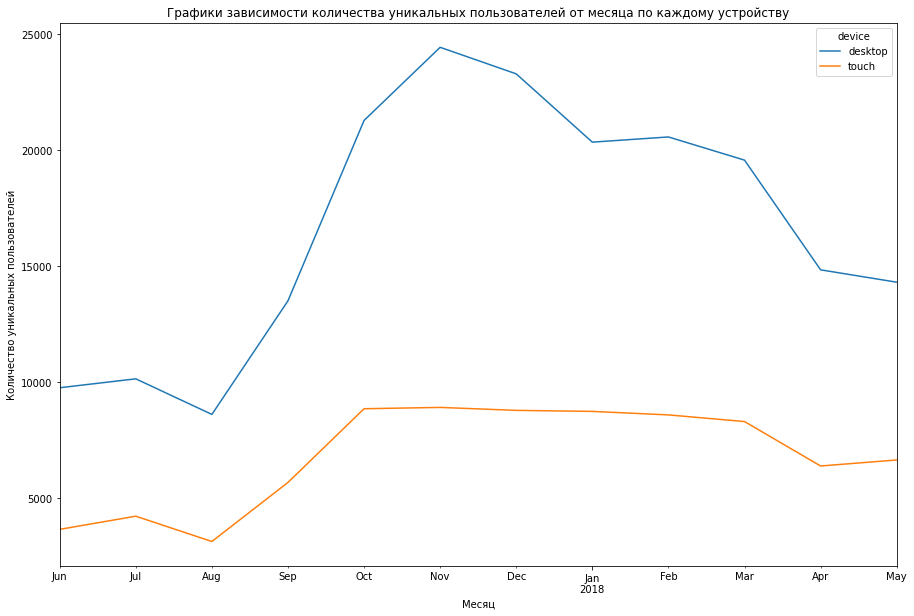

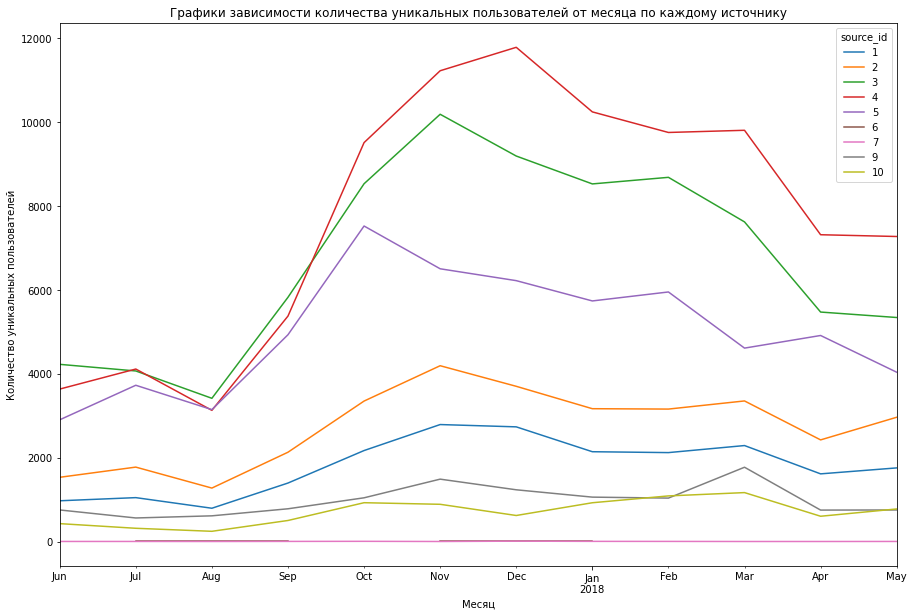

In [13]:
# Нарисуем графики зависимостей DAU, WAU, MAU от сезона по каждому источнику и девайсу

for metric, name_title, name_title_1, name_label in zip(
    list_metrics,
    ['даты', 'даты', 'недели', 'недели', 'месяца', 'месяца'],
    ['устройству', 'источнику', 'устройству', 'источнику', 'устройству', 'источнику'],
    ['Дата', 'Дата', 'Неделя', 'Неделя', 'Месяц', 'Месяц']):
    metric.plot(figsize=(15, 10))
    plt.title(f'Графики зависимости количества уникальных пользователей от {name_title} по каждому {name_title_1}')
    plt.xlabel(name_label)
    plt.ylabel('Количество уникальных пользователей')

In [14]:
# Посчитаем среднее

for metric, name_metric in zip(list_metrics,
                               ['DAU по устройствам', 'DAU по источникам',
                               'WAU по устройства', 'WAU по источникам',
                               'MAU по устройствам', 'MAU по источникам']):
    print(name_metric)
    display(metric.mean().astype('int'))
    print()

DAU по устройствам


device
desktop    659
touch      252
dtype: int64


DAU по источникам


source_id
1      80
2     120
3     232
4     275
5     175
6       1
7       1
9      36
10     26
dtype: int64


WAU по устройства


device
desktop    4135
touch      1637
dtype: int64


WAU по источникам


source_id
1      464
2      716
3     1565
4     1830
5     1168
6        1
7        1
9      238
10     166
dtype: int64


MAU по устройствам


device
desktop    16724
touch       6825
dtype: int64


MAU по источникам


source_id
1     1818
2     2752
3     6758
4     7765
5     5017
6        1
7        2
9      987
10     707
dtype: int64

### Выводы

- Распределения показывают, что пики приходятся на Новогодние каникулы и далее количество уникальных пользователей начинает снижаться.

- Далее в проекте изучим что повлияло на такое распределение, на первый взгляд кажется, что это сезонность или изменение маркетинговой компании.

- Статистика по десктопной версии гораздо лучше мобильной версии. Рекомендуем обратить внимание на мобильную версию, вероятно она требует доработок по UIX.

- Также обращаем внимание, что источники 1, 2, 3, 4, 5 показывают себя хорошо. Рекомендуем сконцентрироваться на них.

- Источники 6 и 7 вообще не приносят траффика, с ними необходимо поработать, например, посмотреть где располагается реклама. Если это слишком трудозатратно, то рекомендуем от них избавиться как от неэффективных.

- Источники 9 и 10 приносят траффик, но не так эффективно как первая группа. Поэтому рекомендуем оптимизировать данные источники: например, изменить расположение рекламы.

---

##  Сколько сессий в день?<a class="anchor" id="five"></a>

In [15]:
sessions_per_user = visits.groupby(['session_date']).agg({'uid': ['count','nunique']})

sessions_per_user.columns = ['n_sessions', 'n_users']

sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
display(sessions_per_user) 

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


Среднее количество сессий в день 1.082169644003972


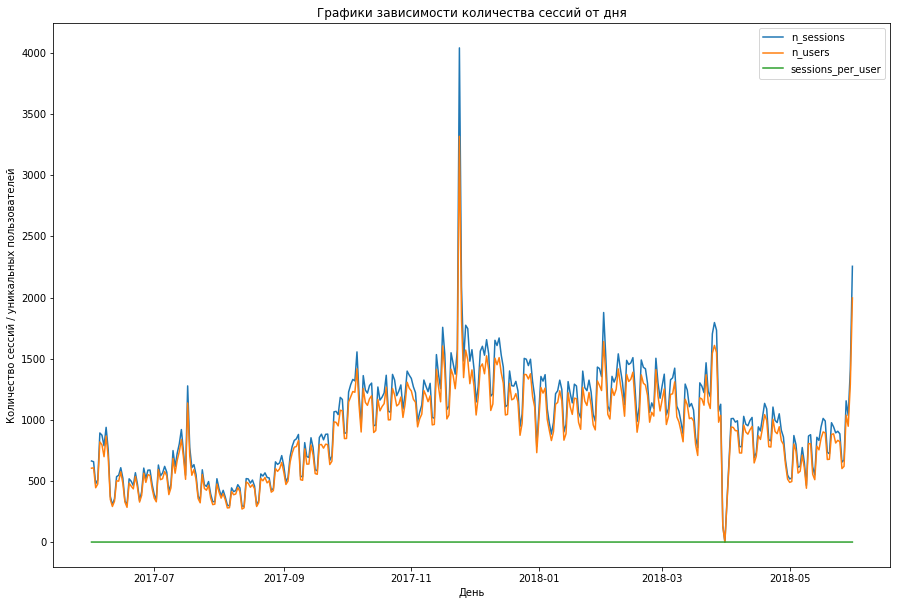

In [16]:
sessions_per_user.plot(figsize=(15, 10))

plt.title('Графики зависимости количества сессий от дня')
plt.xlabel('День')
plt.ylabel('Количество сессий / уникальных пользователей')
sessions_per_user_mean = sessions_per_user['sessions_per_user'].mean()
print(f'Среднее количество сессий в день {sessions_per_user_mean}')

### Выводы

- Распределения показывают, что пики приходятся на Новогодние каникулы.

- Среднее количество сессий в день приближенно к единице. Чисто логически так и должно быть, ведь сервис рассчитан на то, что пользователь зайдет, выберет интересующееся мероприятие, купит на него билет и сходит.

- Количество сессий практически неотличимо от количества новых юзеров - а вот это странно, ведь это показывает, что пользователи зашли, воспользовались один раз сервисом и редко возвращаются.

- В апреле месяце видим, что количество сессий равно нулю - здесь возможны два варианта:
1. Сервис упал;
2. Данных просто нет

In [18]:
from IPython.display import IFrame

<hr style="border: 2px solid green;" />

##  Сколько длится одна сессия?<a class="anchor" id="six"></a>

In [20]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print(visits['session_duration_sec'].mean())

643.506488592098


Text(0, 0.5, 'Длительность сессии')

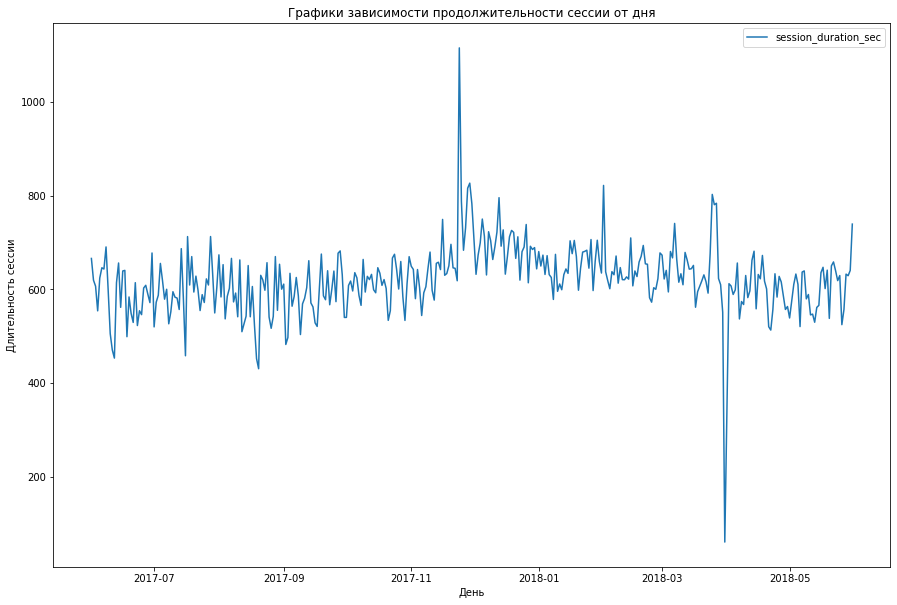

In [21]:
session_duration = visits.groupby('session_date').agg({'session_duration_sec':'mean'})
session_duration.plot(figsize=(15, 10))

plt.title('Графики зависимости продолжительности сессии от дня')
plt.xlabel('День')
plt.ylabel('Длительность сессии')

<AxesSubplot:>

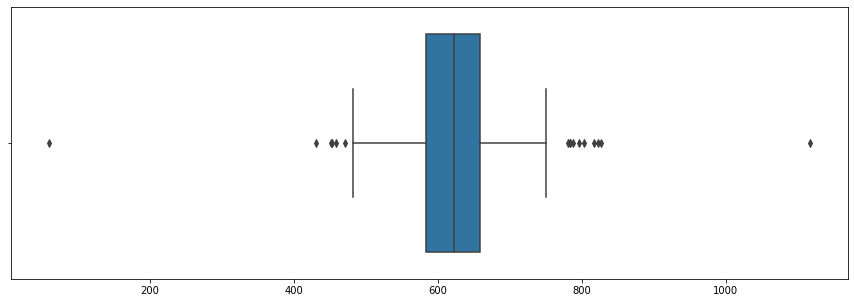

In [23]:
plt.figure(figsize=(15, 5))
sns.boxplot(session_duration)

In [24]:
import statsmodels.api as sm

In [25]:
# функция для отображения гистограммы, боксплота и quantile-quantile plot
def histbox_qqplot(values, figsize=(8, 8), title=None, bins=11, xlabel=None, whis=1.5, 
            flierprops=dict(markerfacecolor='r', marker='s'), boxprops=dict(color='white'), whiskerprops=dict(color='#FFC358'), xlim=None, **kwargs):
    fig = plt.figure(figsize=figsize, dpi=100)
    ax1 = fig.add_subplot(221)
    ax1.set(title=title)
    # гистограмма и боксплот
    ax1.hist(values, bins=bins, label='Гистограмма', **kwargs)
    ax1.set_xlabel(xlabel)
    ax1.legend()
    ax1.set_xlim(xlim)
    ax1.grid(True, color='grey', linestyle='-', linewidth=0.25)
    ax2 = ax1.twinx()

    ax2.boxplot(values, vert=False, whis=whis, notch=True, capprops=whiskerprops, 
                    flierprops=flierprops, boxprops=boxprops, whiskerprops=whiskerprops)
    ax2.set_xlim(xlim)
    ax3 = fig.add_subplot(222)
    ax3.set(title=title)
    # qqplot
    sm.qqplot(values, line='45', fit=True, ax=ax3)
    ax3.grid(True, color='grey', linestyle='-', linewidth=0.25)
    plt.show()

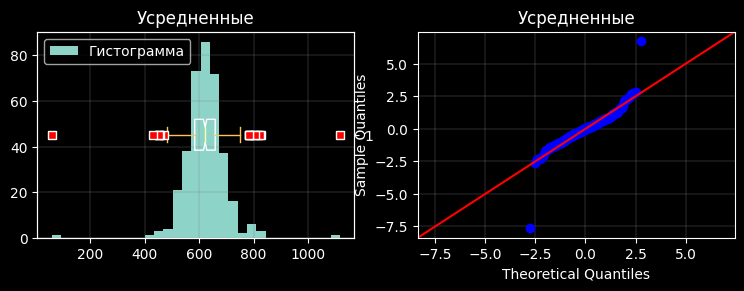

In [26]:
plt.style.use('dark_background')
histbox_qqplot(session_duration.values[:, 0], bins=31, figsize=(9, 6), title='Усредненные')
plt.style.use('classic')

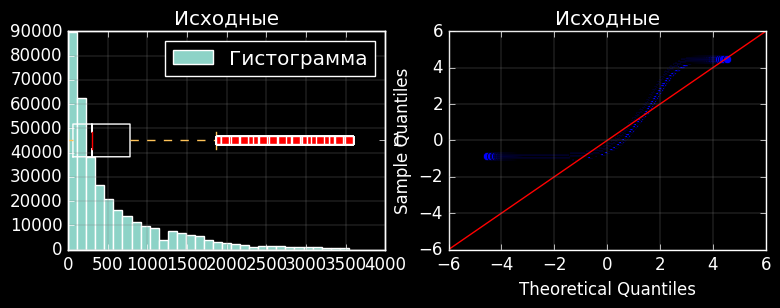

In [27]:
plt.style.use('dark_background')
histbox_qqplot(visits['session_duration_sec'][visits['session_duration_sec'] < 3600], bins=31, figsize=(9, 6), title='Исходные')
plt.style.use('classic')

### Выводы

- Средняя продолжительность сессии в течение года вполне стабильна
- Ближе к Новому году продолжительность сессии увеличивается, видать все более трепетно выбирают мероприятие перед таким важным праздником
- В апреле видим нулевую среднюю сессию - видать сервис все-таки упал

<hr style="border: 2px solid green;" />

##  Как часто люди возвращаются?<a class="anchor" id="seven"></a>

Определим событие и период — на их основе сформируем когорту. Возьмём месяц, когда пользователь впервые проявил активность в Яндекс.Афише.

In [28]:
first_activity_month = visits.groupby(['uid'])['session_month'].min()
first_activity_month.name = 'first_activity_month'
visits = visits.join(first_activity_month, on='uid')

Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты. В качестве делителя обратимся к константе np.timedelta64(1,'M') (где 'M' от англ. month, «месяц»):

In [29]:
visits['cohort_lifetime'] = visits['session_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:

In [30]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

In [31]:
cohorts

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Чтобы найти Retention Rate, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждый следующий месяц.<br>

Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц:

In [32]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
print(initial_users_count) 

   first_activity_month    uid
0            2017-06-01  13259
12           2017-07-01  13140
23           2017-08-01  10181
33           2017-09-01  16704
42           2017-10-01  25977
50           2017-11-01  27248
57           2017-12-01  25268
63           2018-01-01  22624
68           2018-02-01  22197
72           2018-03-01  20589
75           2018-04-01  15709
77           2018-05-01  15273


Переименуем столбец `uid` в `cohort_users`

In [33]:
initial_users_count.columns = ['first_activity_month', 'cohort_users']

Объединим данные по когортам с исходным количеством пользователей в когорте:

In [34]:
cohorts = cohorts.merge(initial_users_count, on='first_activity_month') 

Рассчитаем Retention Rate. Разделим количество активных пользователей в каждый из месяцев на исходное число пользователей в когорте:

In [35]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту:

Text(120.33333333333333, 0.5, 'Когорта')

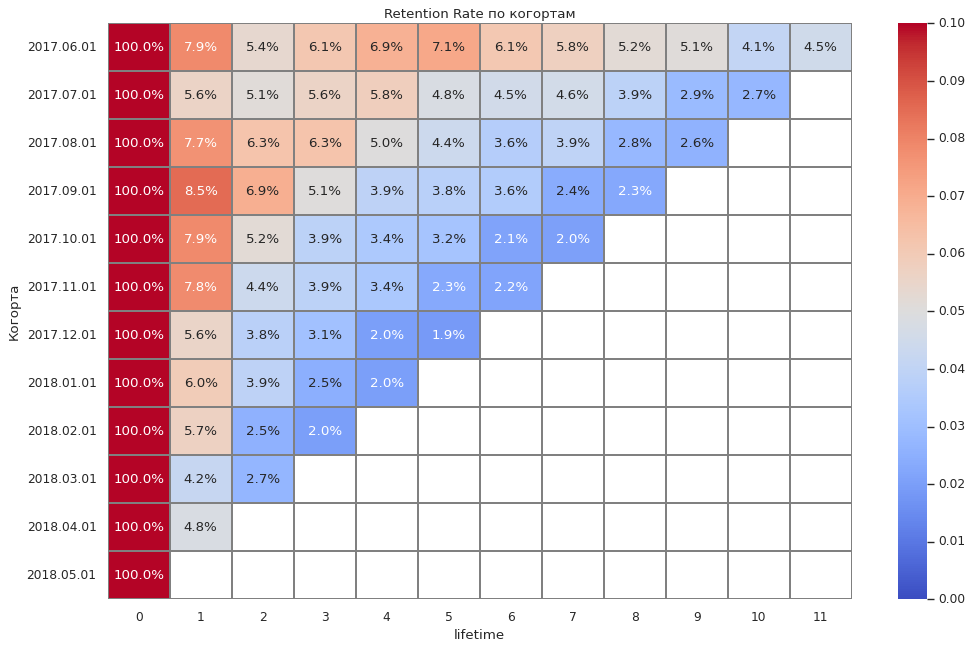

In [36]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, 
            annot=True,
            fmt='.1%',
            linewidths=1,
            linecolor='gray',
            yticklabels=retention_pivot.index.strftime('%Y.%m.%d'),
            vmin=0.0,
            vmax=0.1,
            cmap='coolwarm'
           )
plt.title('Retention Rate по когортам')
plt.xlabel('lifetime')
plt.ylabel('Когорта')

### Выводы

Retention Rate для всех когорт выглядит крайне низким. Рекомендуем увеличить качество продукта и увеличить маркетинг.

<hr style="border: 2px solid green;" />

##  2.2. Продажи:<a class="anchor" id="eight"></a>

##  Когда люди начинают покупать?<a class="anchor" id="nine"></a>

Вычислим время первой покупки для каждого пользователя

In [37]:
first_order_date = orders.groupby(['uid'])['buy_ts'].min()
first_order_date.name = 'first_order_time'
first_order_date

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: first_order_time, Length: 36523, dtype: datetime64[ns]

In [38]:
orders = orders.set_index('uid')

In [39]:
orders = orders.merge(first_order_date, on='uid')

In [40]:
orders

,buy_ts,revenue,first_order_time
uid,,,
10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01 00:10:00
11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01 00:25:00
17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01 00:27:00
16109239769442553005,2017-06-01 00:29:00,0.55,2017-06-01 00:29:00
14200605875248379450,2017-06-01 07:58:00,0.37,2017-06-01 07:58:00
...,...,...,...
12296626599487328624,2018-05-31 23:50:00,4.64,2018-05-31 23:50:00
11369640365507475976,2018-05-31 23:50:00,5.80,2018-05-31 23:50:00
1786462140797698849,2018-05-31 23:54:00,0.30,2018-05-31 23:54:00


Вычислим время первой сессии

In [41]:
first_activity_time = visits.groupby(['uid'])['start_ts'].min()
first_activity_time.name = 'first_activity_time'
first_activity_time.head(3)

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
Name: first_activity_time, dtype: datetime64[ns]

In [38]:
orders.head(3)

,buy_ts,revenue,first_order_time
uid,,,
10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01 00:10:00
11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01 00:25:00
17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01 00:27:00


In [42]:
orders = orders.merge(first_activity_time, on='uid')

Вычислим период от первого использования до первой покупки

In [43]:
orders['first_order_period'] = (orders['first_order_time'] - orders['first_activity_time']).dt.seconds

In [44]:
orders['first_order_period'].mean()

17079.371615590597

In [45]:
orders.head(3)

,buy_ts,revenue,first_order_time,first_activity_time,first_order_period
uid,,,,,
10329302124590727494,2017-06-01 00:10:00,17.00,2017-06-01 00:10:00,2017-06-01 00:09:00,60
11627257723692907447,2017-06-01 00:25:00,0.55,2017-06-01 00:25:00,2017-06-01 00:14:00,660
17903680561304213844,2017-06-01 00:27:00,0.37,2017-06-01 00:27:00,2017-06-01 00:25:00,120


In [46]:
orders['cohort_month'] = orders['buy_ts'].astype('datetime64[M]')

Визуализируем результаты

first_order_period    1500.0
dtype: float64

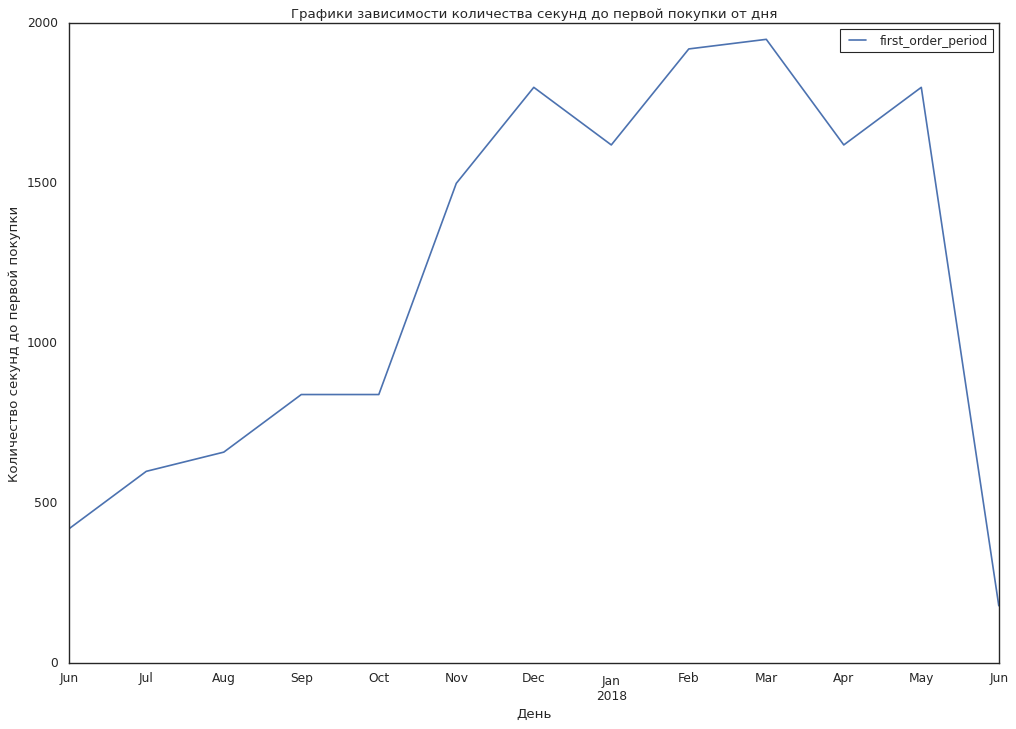

In [47]:
orders_period = orders.groupby('cohort_month').agg({'first_order_period':'median'})
orders_period.plot(figsize=(15, 10))

plt.title('Графики зависимости количества секунд до первой покупки от дня')
plt.xlabel('День')
plt.ylabel('Количество секунд до первой покупки')

orders_period.median()

In [48]:
orders['first_order_period'].describe()

count    50415.000000
mean     17079.371616
std      27347.765209
min          0.000000
25%        240.000000
50%       1200.000000
75%      21780.000000
max      86340.000000
Name: first_order_period, dtype: float64

### Выводы

Время между первым визитом и первой покупкой достаточно высокое. В качестве рекомендации предлагаем поработать над формой покупки и уменьшить количество кликов для выполнения покупки.

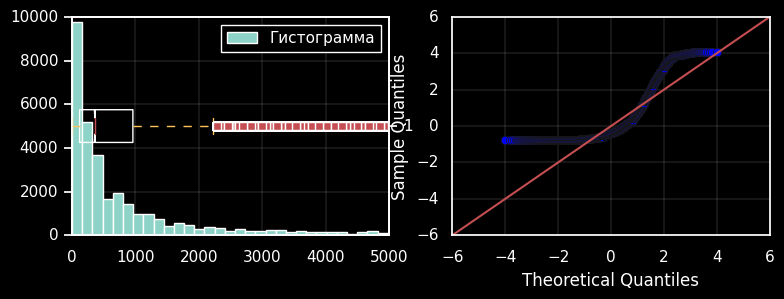

In [49]:
plt.style.use('dark_background')
histbox_qqplot(orders['first_order_period'][orders['first_order_period']<5000], bins=31, figsize=(9, 6))
plt.style.use('classic')

In [50]:
orders['first_order_period'].describe()

count    50415.000000
mean     17079.371616
std      27347.765209
min          0.000000
25%        240.000000
50%       1200.000000
75%      21780.000000
max      86340.000000
Name: first_order_period, dtype: float64

<hr style="border: 2px solid green;" />

##  Сколько раз покупают за период?<a class="anchor" id="ten"></a>

Распакуем количество покупок по месяцам в зависимости от девайса и источника, предварительно определив первый источник и девайс для каждого пользователя.

In [51]:
sources = visits.sort_values(by= ['uid', 'start_ts']).groupby(['uid']).agg({'source_id':'first'})

In [52]:
devices = visits.sort_values(by= ['uid', 'start_ts']).groupby(['uid']).agg({'device':'first'})

In [53]:
orders = orders.merge(sources, on = 'uid')

In [54]:
orders = orders.merge(devices, on = 'uid')

In [55]:
orders = orders.reset_index()

In [56]:
list_orders = order_per_month_device, order_per_month_source = [
    orders.pivot_table(
        index = 'cohort_month',
        columns = category,
        values = 'uid',
        aggfunc = 'count')
    for category in ('device', 'source_id')  
]

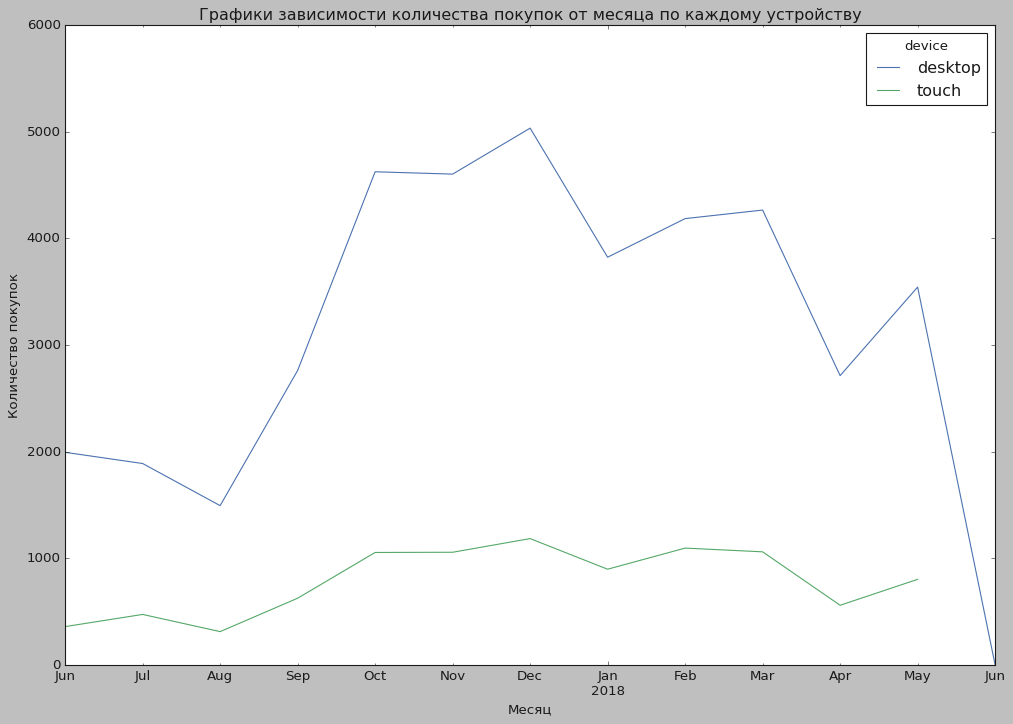

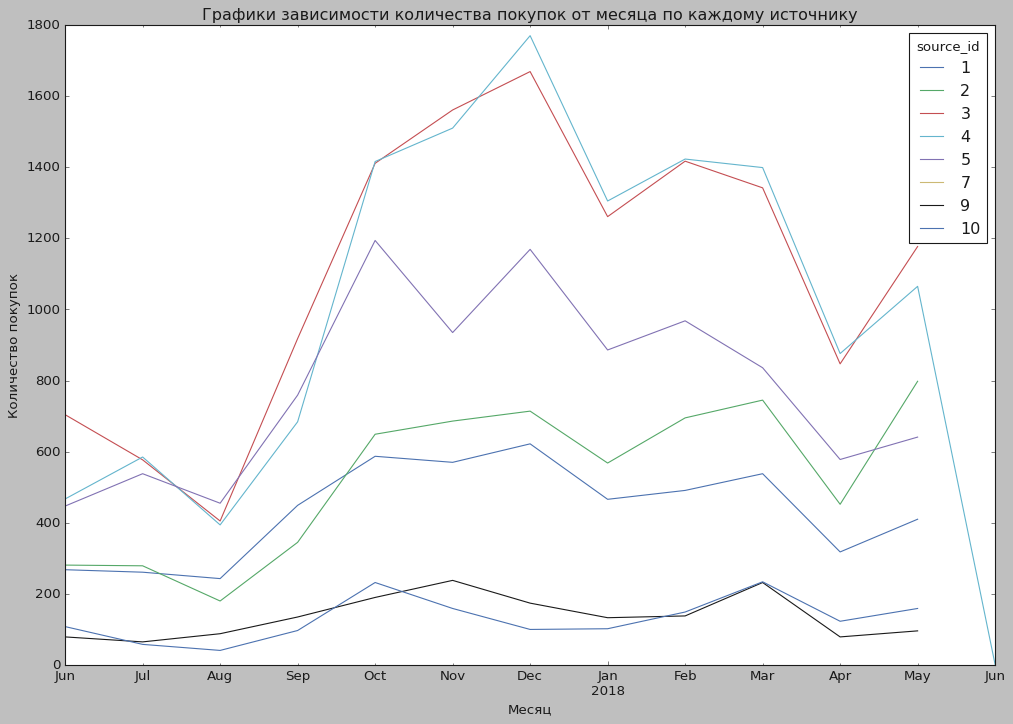

In [57]:
# Нарисуем графики зависимостей количества покупок от месяца по каждому источнику и девайсу

for order_data, name_title_1 in zip(
    list_orders,
    ['устройству', 'источнику']):
    order_data.plot(figsize=(15, 10))
    plt.title(f'Графики зависимости количества покупок от месяца по каждому {name_title_1}')
    plt.xlabel('Месяц')
    plt.ylabel('Количество покупок')

### Выводы

- Через мобильное приложение крайне редко совершают покупки. Поэтому определенно точно рекомендуем изменить UIX приложение, т.к. в наши дни все пользуются мобильными устройствами и такой траффик упускать нельзя.

- Количество покупок из десктопа в целом растет.

- По продажам 1, 2 и 5 источники показывают себя хорошо. Рекомендуем и далее проводить маркетинг с данными источниками.

- Источники 3 и 4 хоть и показывают результаты, но достаточно низкий. Рекомендуем над ним поработать, возможно изменить расположение рекламы.

- Источники 7, 9 и 10 показывают крайне низкие результаты. Над ними определенно нужна работа, либо отказ от них в случае их дороговизны.

<hr style="border: 2px solid green;" />

##  Какой средний чек?<a class="anchor" id="eleven"></a>

Присоединяем агрегированные покупки

In [58]:
report_source = orders.groupby(['uid', 'cohort_month']).agg({'revenue':'mean'})
report_source.columns = ['revenue_mean']
report_source = report_source.reset_index()

In [59]:
report_source = report_source.merge(orders, on=['uid', 'cohort_month'])

In [60]:
report_source.head()

,uid,cohort_month,revenue_mean,buy_ts,revenue,first_order_time,first_activity_time,first_order_period,source_id,device
0,313578113262317,2018-01-01,0.550,2018-01-03 21:51:00,0.55,2018-01-03 21:51:00,2017-09-18 22:49:00,82920,2,desktop
1,1575281904278712,2017-06-01,1.525,2017-06-03 10:13:00,1.22,2017-06-03 10:13:00,2017-06-03 10:13:00,0,10,touch
2,1575281904278712,2017-06-01,1.525,2017-06-03 17:39:00,1.83,2017-06-03 10:13:00,2017-06-03 10:13:00,0,10,touch
3,2429014661409475,2017-10-01,73.330,2017-10-11 18:33:00,73.33,2017-10-11 18:33:00,2017-10-11 17:14:00,4740,3,desktop
4,2464366381792757,2018-01-01,2.440,2018-01-28 15:54:00,2.44,2018-01-28 15:54:00,2018-01-27 20:10:00,71040,5,desktop


Считаем средний чек

In [62]:
report = report_source.pivot_table(index = 'cohort_month', 
                                   columns = 'source_id', 
                                   values = 'revenue',
                                   aggfunc = 'mean')

Выведем первые пять строк таблицы

In [63]:
report.head()

source_id,1,2,3,4,5,7,9,10
cohort_month,,,,,,,,
2017-06-01,5.144403,3.714164,3.983438,4.196660,4.248076,NaN,3.072025,2.123611
2017-07-01,6.060077,6.698602,5.542097,4.928701,4.801004,NaN,3.650308,3.234310
2017-08-01,5.932058,5.161222,4.851778,4.601726,4.671956,1.22,3.372386,4.548537
2017-09-01,6.841002,6.986029,5.075022,4.533173,5.860356,NaN,3.406444,2.023505
2017-10-01,6.170051,8.192280,4.340992,4.240247,4.637789,NaN,4.260632,2.468621


Text(0, 0.5, 'Средний чек')

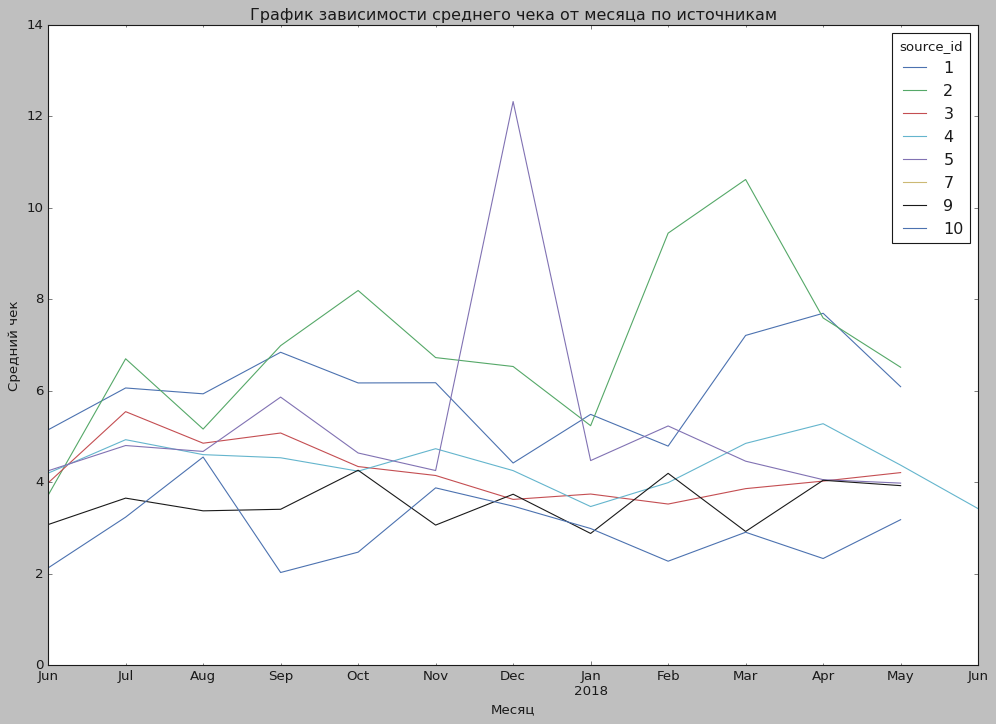

In [64]:
# Нарисуем графики зависимостей среднего чека от месяца

report.plot(figsize=(15, 10))
plt.title(f'График зависимости среднего чека от месяца по источникам')
plt.xlabel('Месяц')
plt.ylabel('Средний чек')

### Выводы

По графику видим незначительное снижение среднего чека. Поэтому рекомендуем увеличить затраты на маркетинг.

Также хочется отметить источники 1, 2 и 4 - они дают наибольший средний чек, поэтому следует сконцентрироваться на них

Иточник 7 вообще не показан на графике и поэтому над ним следует поработать.

Источники 3, 5, 9 и 10 дают средний чек ниже, поэтому с ними следует поработать.

<hr style="border: 2px solid green;" />

##  Сколько денег приносят? (LTV)<a class="anchor" id="twelve"></a>

In [65]:
# определяем источник пользователя
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})

sources.columns = ['first_source']

# соединяем первые покупки и источники 
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})

# считаем ltv
ltv = payers.merge(orders, on = 'uid')
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy']) / np.timedelta64(1,'M')).round().astype(int)
orders_lifetime = ltv.pivot_table(index = 'first_source',
                                  columns = 'lifetime',
                                  values = 'revenue',
                                  aggfunc = 'count').fillna(0)

buyers_lifetime = ltv.pivot_table(index = 'first_source',
                                  columns = 'lifetime',
                                  values = 'uid',
                                  aggfunc = 'nunique').fillna(0)
ltv = ltv.pivot_table(index = 'first_source',
                      columns = 'lifetime',
                      values = 'revenue',
                      aggfunc = 'sum').fillna(0)
ltv = ltv.cumsum(axis = 1)

# добавляем размеры когорт и делим на них
# div(ltv['cohort_size'], axis = 0) берет столбец cohort_size и делит на него каждый столбец фрейма
cohort_sizes = payers.groupby('first_source').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
ltv = ltv.merge(cohort_sizes, on = 'first_source')
ltv = ltv.div(ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size')
display(ltv)

,0,1,2,3,4,5,6,7,8,9,10,11,12
first_source,,,,,,,,,,,,,
1,6.156185,7.150835,7.891156,8.537754,9.029303,9.251083,9.525826,9.866858,10.191256,10.450862,10.557561,10.673508,10.724577
2,6.770593,8.054740,9.717921,11.253637,11.900125,12.484390,12.721418,12.948380,13.171358,13.233560,13.346994,13.380422,13.383802
3,4.477694,4.729283,4.865748,5.008149,5.083093,5.122590,5.147003,5.173669,5.192354,5.197477,5.202699,5.203834,5.204931
4,4.584762,4.738128,4.852278,4.948617,5.068362,5.226563,5.342363,5.391025,5.410340,5.448244,5.502627,5.505380,5.506685
5,4.909883,5.114191,5.469974,6.836748,7.072747,7.246335,7.365203,7.454998,7.515129,7.576270,7.582746,7.592303,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.880901,4.167390,4.408024,4.678888,4.788189,4.935588,5.059127,5.126608,5.244430,5.284972,5.293566,5.293566,5.293566
10,3.164131,3.227434,3.254695,3.302558,3.316576,3.319217,3.332724,3.343348,3.346102,3.348631,3.348631,3.348631,3.348631


### Выводы

Как показывает ltv самые успешные в росте это когорты из источников: 1, 2 и 5. Поэтому рекомендуем и далее пользоваться данными источниками.

Когорты из 3, 4 и 9 источников растут, но при этом медленно. Поэтому рекомендуем простимулировать их.

Когорты из оставшихся когорт пребывают в стагнации. Рекомендуем поработать над ними, либо отказаться от них в случае их дороговизны.

<hr style="border: 2px solid green;" />

##  2.3. Маркетинг<a class="anchor" id="thirteen"></a>

##  Сколько денег потратили? Всего / на каждый источник / по времени]<a class="anchor" id="fourteen"></a>

##  Сколько стоило привлечение одного покупателя из каждого источника?<a class="anchor" id="fifteen"></a>

In [66]:
# считаем САС

cohort_sizes = cohort_sizes.reset_index()
cohort_sizes.columns = ['source_id', 'cohort_size']
cac = costs.groupby('source_id').agg({'costs': 'sum'}).merge(cohort_sizes, on = 'source_id')
cac['cac'] = cac['costs'] / cac['cohort_size']
display(cac)

,source_id,costs,cohort_size,cac
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10296,5.931779
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106


### Выводы

Как оказалось самый неэффективный источник оказался еще и бесплатным) Ну что ж хотя бы денег не просит.

Источники 1, 4 и 5 достаточно низкие по затратам и имеют хорошие показатели.

Источники 2 и 3 оказались самыми дорогими, при этом другие показатели у них тоже достойные, поэтому здесь нужна аналитика по окупаемости.

Источники 9 и 10 имеют низкую цену, при этом и показатели их достаточно низкие.

<hr style="border: 2px solid green;" />

##  На сколько окупились расходы? (ROI)<a class="anchor" id="sixteen"></a>

Для расчета ROI нам понадобиться смержить `cac` с `ltv`, для удобства переименуем столбец в `cac`

In [67]:
cac = cac.rename(columns={'source_id':'first_source'})

In [68]:
cac = cac.set_index('first_source')

In [69]:
# считаем ROI

roi = ltv.merge(cac['cac'], on = 'first_source')
roi = roi.div(roi['cac'], axis = 0).drop(columns = 'cac')
roi

,0,1,2,3,4,5,6,7,8,9,10,11,12
first_source,,,,,,,,,,,,,
1,0.856648,0.995056,1.098073,1.188049,1.256449,1.287311,1.325542,1.372997,1.418138,1.454263,1.469110,1.485245,1.492351
2,0.554541,0.659718,0.795940,0.921722,0.974672,1.022526,1.041939,1.060528,1.078791,1.083886,1.093177,1.095915,1.096191
3,0.331831,0.350476,0.360589,0.371142,0.376696,0.379623,0.381432,0.383408,0.384793,0.385172,0.385559,0.385643,0.385725
4,0.772915,0.798770,0.818014,0.834255,0.854442,0.881112,0.900634,0.908838,0.912094,0.918484,0.927652,0.928116,0.928336
5,0.657502,0.684862,0.732506,0.915536,0.947140,0.970386,0.986304,0.998329,1.006381,1.014569,1.015436,1.016716,1.016750
9,0.765279,0.821772,0.869223,0.922635,0.944188,0.973254,0.997615,1.010922,1.034155,1.042150,1.043844,1.043844,1.043844
10,0.722222,0.736671,0.742894,0.753818,0.757018,0.757621,0.760704,0.763129,0.763757,0.764335,0.764335,0.764335,0.764335


Выполним визуализацию в виде тепловой карты

Text(120.33333333333333, 0.5, 'Источник')

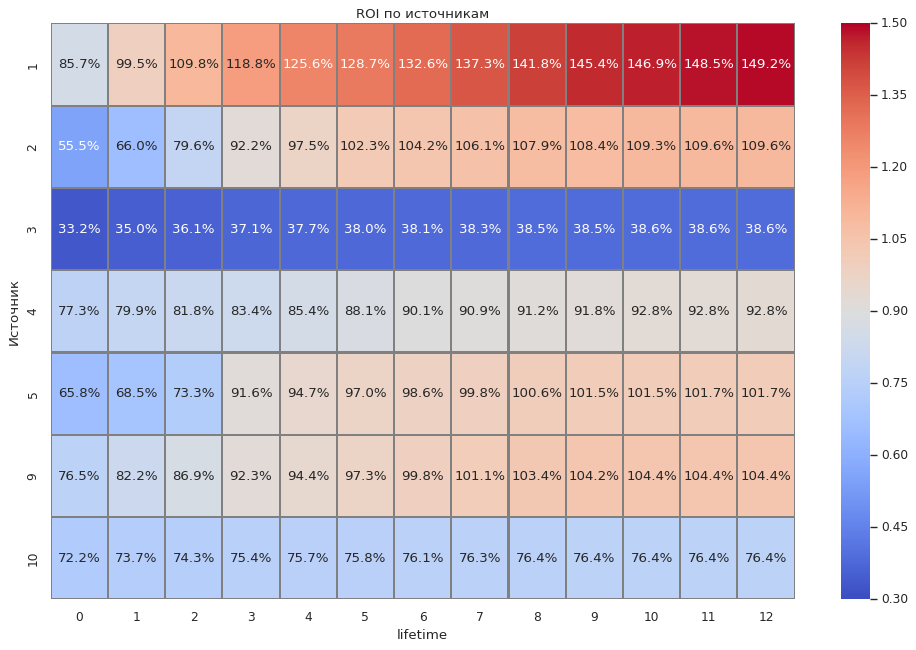

In [70]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Источники: ROI')
sns.heatmap(roi, 
            annot=True,
            fmt='.1%',
            linewidths=1,
            linecolor='gray',
            vmin=0.3,
            vmax=1.5,
            cmap='coolwarm'
           )
plt.title('ROI по источникам')
plt.xlabel('lifetime')
plt.ylabel('Источник')

Выполним визуализацию

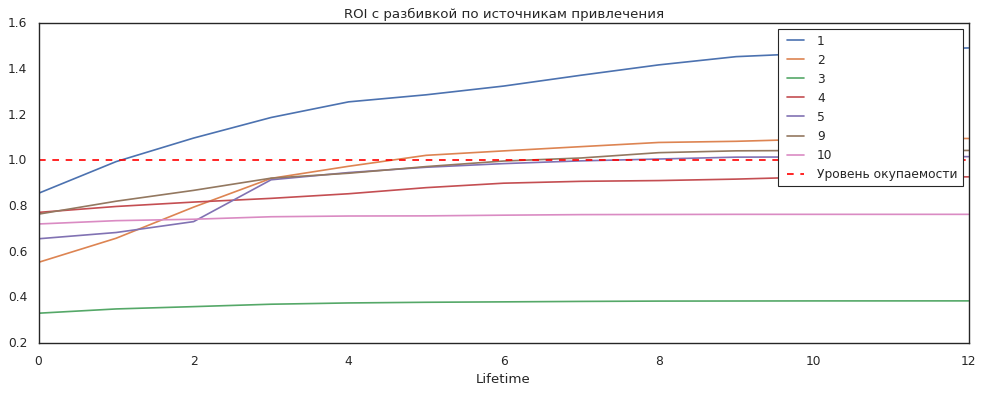

In [71]:
roi.T.plot(figsize = (15, 5))
plt.axhline(y = 1, label = 'Уровень окупаемости', color = 'red', linestyle = '--')
plt.title('ROI с разбивкой по источникам привлечения')
plt.xlabel('Lifetime')
plt.legend()
plt.show()

### Выводы

Из графика видим, что первый источник окупился в первый же месяц. Следовательно, это выгодное вложение, стоит и далее работать с этим источником.

Источки 2, 9 и 5 окупились в течение 6 месяцев. Это хорошие источники по окупаемости, с ними также стоит работать.

Источники 3, 10 и 4 не окупились совсем. С данными источниками необходима работа, например изменить условия работы и запросить скидку.

<hr style="border: 2px solid green;" />

##  3. Общий вывод<a class="anchor" id="seventeen"></a>

Для оптимизации маркетинговых затрат рекомендуем следующее:

1. Необходимо развивать мобильную версию сервиса, т.к. траффик из данного девайса крайне низок. Нужно оптимизировать UIX, чтобы приложением стало удобнее пользоваться. В наши дни мобильный траффик - один из самых **жирных** поэтому нельзя упускать такой возможности.

2. Рекомендуем сосредоточиться на десктопной версии приложения т.к. основной траффик приходится на него.

3. Как показывает ROI самые выгодные и окупаемые источники: 1, 2, 5 и 9. Стоит и далее сотрудничать с данными источниками.

4. По источнику 3, 4 и 10 необходимо запросить скидку и оптимизировать расположение рекламы. Если так и дальше пойдет дело, то будут тянуть всю прибыль ко дну. Конечно, если это стратегические партнеры, от которых появляется положительный репутационный эффект и улучшается нетворкинг, то нужно учесть все риски.